In [12]:
import pandas as pd
import numpy as np

# ntlk stuff
import nltk
from nltk import pos_tag
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# Vizzies
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Words Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# For Latent Semantic Analysis (LSA)
from sklearn.decomposition import TruncatedSVD

# Classifier Algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Model Selection & Evaluation
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, log_loss
from sklearn.pipeline import Pipeline

# tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

# scikeras
from scikeras.wrappers import KerasClassifier

# xgboost
from xgboost import XGBClassifier

In [13]:
import pandas as pd

# Specify the path to your CSV file
csv_path = 'data/train_essays.csv'

# Use pandas to read the CSV file into a DataFrame
df3 = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame to verify the import
df3.head()


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [14]:
import pandas as pd

# Specify the paths to your CSV files
csv_path1 = 'data/ai_generated_train_essays.csv'
csv_path2 = 'data/ai_generated_train_essays_gpt-4.csv'

# Use pandas to read the CSV files into DataFrames
df1 = pd.read_csv(csv_path1)
df2 = pd.read_csv(csv_path2)

# Concatenate the two DataFrames
df = pd.concat([df3, df1, df2], ignore_index=True)

# Display the first few rows of the concatenated DataFrame
df.head()


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [15]:
df['generated'].value_counts()

generated
0    1375
1     703
Name: count, dtype: int64

In [16]:
def tokenize_text(text, tokenizer, stopwords_list):
    # Standardize case (lowercase the text)
    text = text.lower()
    
    # Tokenize text using `tokenizer`
    tokens = tokenizer.tokenize(text)
    
    # Remove stopwords using `stopwords_list`
    filtered_tokens = [word for word in tokens if word not in stopwords_list]
    
    # Return the preprocessed text
    return filtered_tokens

In [17]:
#nltk.download('stopwords')

In [18]:
import nltk

# Uncomment the line below and run it once to download the stopwords dataset
# nltk.download('stopwords')

# Defining a RegEx pattern for use in our tokenizer
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

# Instantiate the tokenizer and pass the RegEx pattern
tokenizer = RegexpTokenizer(pattern)

# Defining stopwords list from NLTK
stopwords_list = stopwords.words('english')


In [19]:
df['tokenized'] = df['text'].apply(lambda x: tokenize_text(x, tokenizer, stopwords_list))


In [20]:
# This will translate the Part of Speech tags that WordNetLemmatizer produces 
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# This is the lemmatize function
def lemmatize_with_pos(tokens):
    lemmatizer = WordNetLemmatizer()
    pos_tokens = pos_tag(tokens)
    return [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tokens]

In [21]:
#nltk.download('averaged_perceptron_tagger')

In [22]:
#nltk.download('wordnet')

In [23]:
df['lemmatized'] = df.tokenized.apply(lemmatize_with_pos)

In [24]:
# Function that will chart token frequencies for each class
def token_freq(dataframe, column):
    
    for x in range(0,2):
        token_list = []
        for tokens in dataframe[dataframe['generated'] == x][column].values:
            token_list.extend(tokens)
            
        fdist = FreqDist(token_list)
        plt.figure(figsize=(12, 2))
        print(f'Class {x}')
        fdist.plot(30);

Class 0


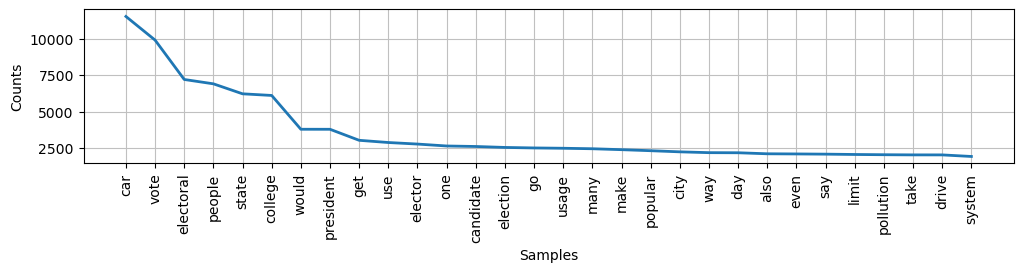

Class 1


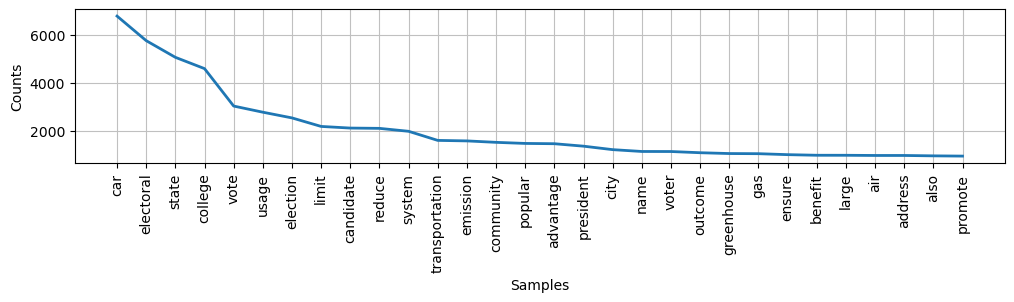

In [25]:
token_freq(df, 'lemmatized')

In [26]:
# global random state for reproducibility
random_state = 0

In [55]:
def fit_score(estimator, vectorizer, dataframe=df, random_state=random_state, lsa=False, lsa_components=100):
    '''
    Prints the model type, vectorizer type, as well as train and test accuracy. 
    Also prints a classification report and plots a confusion matrix on the test data.
    
    Parameters:
    estimator - sklearn estimator
    vectorizer - sklearn word vectorizer
    dataframe - df containing cleaned dataset
    random_state - random state to be used
    lsa - whether or not to apply Latent Semantic Analysis to reduce dimensionality
    lsa_components - n_components hyperparameter for LSA
    '''
    
    # Convert lists of tokens to space-separated strings
    dataframe['tokenized_str'] = dataframe['tokenized'].apply(lambda tokens: ' '.join(tokens))
    
    # vectorize
    if lsa == True:
        svd = TruncatedSVD(n_components=lsa_components, random_state=random_state)
        X = svd.fit_transform(vectorizer.fit_transform(dataframe['tokenized_str']))
    else:
        X = vectorizer.fit_transform(dataframe['tokenized_str'])
            
    # target
    y = dataframe['generated']
    
    # 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=random_state)
    
    # fit model
    estimator.fit(X_train, y_train)
    
    # training acc, testing acc
    train_acc, test_acc = estimator.score(X_train, y_train), estimator.score(X_test, y_test)
    
    # loss
    test_loss = log_loss(y_test, estimator.predict_proba(X_test))
    
    print(f'Model: {estimator}')
    print(f'Vectorizer: {vectorizer}')
    print(f'Train accuracy: {train_acc*100:.1f}%')
    print(f'Test accuracy: {test_acc*100:.1f}%')
    print(f'Test loss: {test_loss:.3f}')
    
    print('\n\nClassification Report (Test Data):')
    print(classification_report(y_test, estimator.predict(X_test)))
    
    cm = ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)
    cm.ax_.set_title('Conf Matrix on Test Data')


Model: LogisticRegression(n_jobs=-1, random_state=0)
Vectorizer: TfidfVectorizer(max_features=1500)
Train accuracy: 100.0%
Test accuracy: 98.6%
Test loss: 0.316


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1308
           1       1.00      0.96      0.98       667

    accuracy                           0.99      1975
   macro avg       0.99      0.98      0.98      1975
weighted avg       0.99      0.99      0.99      1975



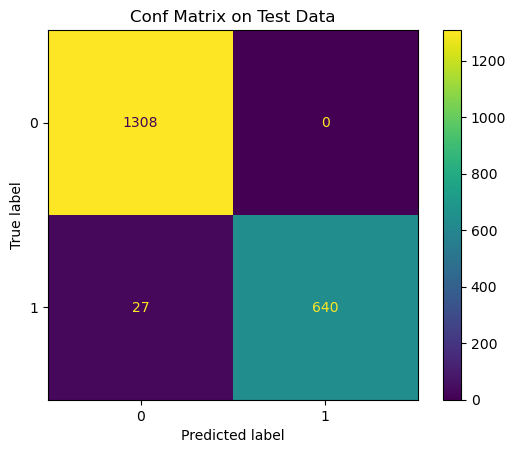

In [53]:
fit_score(LogisticRegression(max_iter=100, random_state=random_state, n_jobs=-1), TfidfVectorizer(max_features=1500))

In [38]:
df['generated'].value_counts()


generated
0    1375
1     703
Name: count, dtype: int64

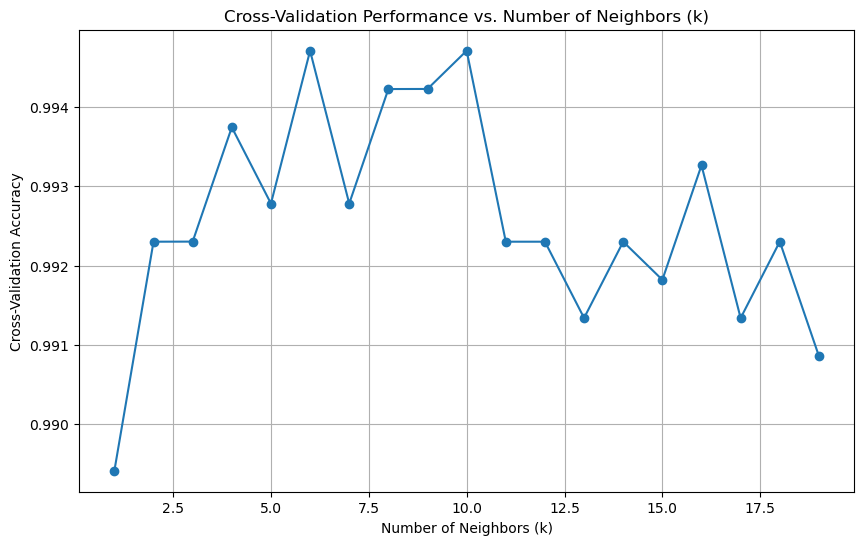

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
X = df['tokenized_str']
y = df['generated']

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1500)
X_vectorized = vectorizer.fit_transform(X)

# Define a range of k values to test
k_values = list(range(1, 20))  # You can adjust this range

# Initialize lists to store cross-validation scores
cv_scores = []

# Perform k-fold cross-validation for each k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_vectorized, y, cv=5)  # 5-fold cross-validation
    cv_scores.append(scores.mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o', linestyle='-')
plt.title('Cross-Validation Performance vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)
plt.show()


generated
0    1375
1     703
Name: count, dtype: int64


Model: KNeighborsClassifier(n_jobs=-1, n_neighbors=6)
Vectorizer: TfidfVectorizer()
Train accuracy: 94.2%
Test accuracy: 93.2%
Test loss: 0.274


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1308
           1       0.83      1.00      0.91       667

    accuracy                           0.93      1975
   macro avg       0.92      0.95      0.93      1975
weighted avg       0.94      0.93      0.93      1975



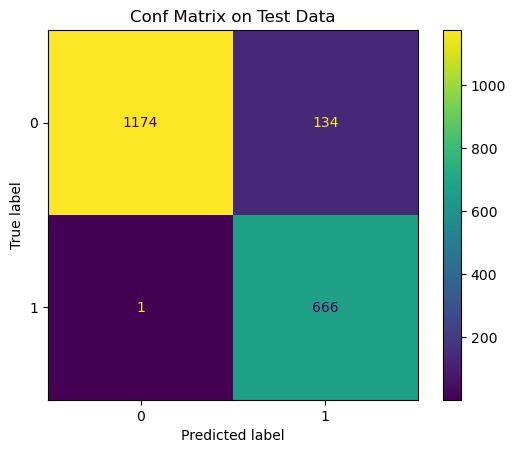

In [61]:
# best KNN
fit_score(KNeighborsClassifier(n_neighbors=6, n_jobs=-1), TfidfVectorizer())

Model: DecisionTreeClassifier(max_depth=25, random_state=0)
Vectorizer: TfidfVectorizer()
Train accuracy: 100.0%
Test accuracy: 99.5%
Test loss: 0.164


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1308
           1       0.99      0.99      0.99       667

    accuracy                           1.00      1975
   macro avg       0.99      1.00      0.99      1975
weighted avg       1.00      1.00      1.00      1975



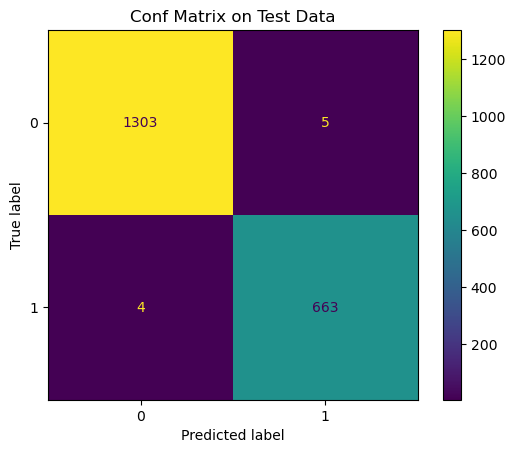

In [62]:
# decision tree
fit_score(DecisionTreeClassifier(random_state=random_state, max_depth=25), TfidfVectorizer(), lsa=True, lsa_components=750)

Model: RandomForestClassifier(random_state=0)
Vectorizer: TfidfVectorizer()
Train accuracy: 100.0%
Test accuracy: 80.5%
Test loss: 0.490


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1308
           1       1.00      0.42      0.59       667

    accuracy                           0.81      1975
   macro avg       0.89      0.71      0.73      1975
weighted avg       0.85      0.81      0.78      1975



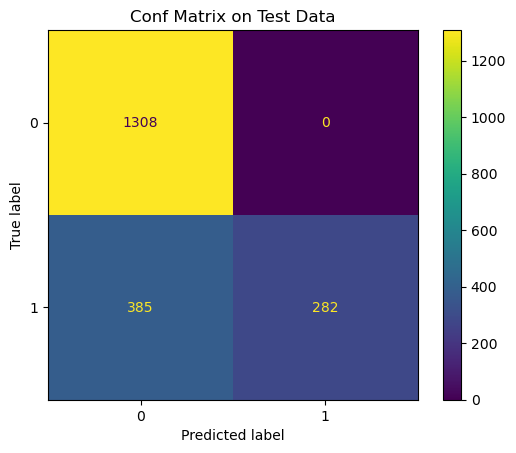

In [63]:
# random forest
fit_score(RandomForestClassifier(random_state=random_state), TfidfVectorizer(), lsa=True, lsa_components=750)

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)
Vectorizer: TfidfVectorizer()
Train accuracy: 100.0%
Test accuracy: 99.6%
Test loss: 0.035


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1308
 

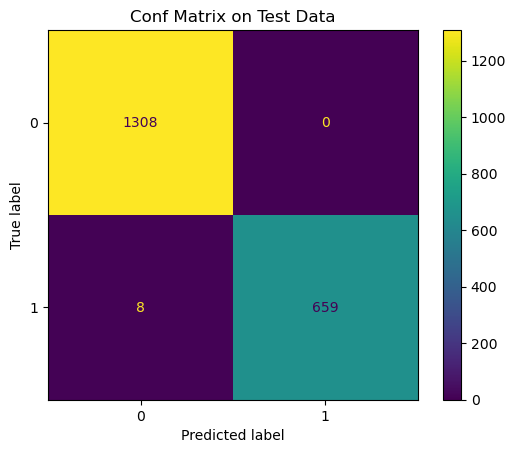

In [64]:
fit_score(XGBClassifier(random_state=random_state), TfidfVectorizer(), lsa=True, lsa_components=750)

In [70]:
# build stacking classifier
stack = StackingClassifier([
    ('knn', KNeighborsClassifier(n_neighbors=6)),
    ('logreg', LogisticRegression(max_iter=1000, penalty=None))
])

Model: StackingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=6)),
                               ('logreg',
                                LogisticRegression(max_iter=1000,
                                                   penalty=None))])
Vectorizer: TfidfVectorizer()
Train accuracy: 100.0%
Test accuracy: 99.8%
Test loss: 0.070


Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1308
           1       1.00      0.99      1.00       667

    accuracy                           1.00      1975
   macro avg       1.00      1.00      1.00      1975
weighted avg       1.00      1.00      1.00      1975



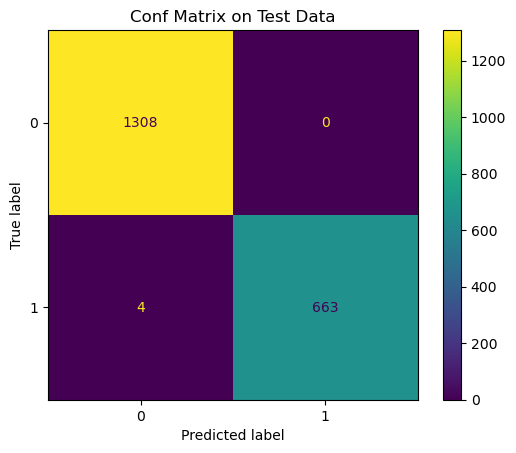

In [71]:
# incorporating LSA
fit_score(stack, TfidfVectorizer(), lsa=True, lsa_components=750)